<a id="top"></a>
# Прогнозирование оттока клиентов банка
<h4 align="right">Спринт 6    |    Когорта ДС13    |    Артур Урусов</h4>

> Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

> Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

> Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

> Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

> Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Содержание

0. **[Подготовка](#0)**

    0.1. [Импорт библиотек](#0-1)
    
    0.2. [Настройка окружения](#0-2)


1. **[Получение данных](#1)**

    1.1. [Чтение файла](#1-1)
    
    1.2. [Изучение данных](#1-2)
    
    1.3. [OHE и заполнение пропусков](#1-3)


2. **[Исследование задачи](#2)**

    2.1. [Подготовка](#2-1)
    
    2.2. [Логистическая регрессия](#2-2)
        
    2.3. [Решающее дерево](#2-3)
    
    2.4. [Случайный лес](#2-4)
    
    2.5. [Баланс и ROC-AUC](#2-5)
    

3. **[Борьба с дисбалансом](#3)**

    3.1. [Балансировка](#3-1)
    
    3.2. [Уменьшение выборки](#3-2)
    
    3.3. [Увеличение выборки](#3-3)
    
    3.4. [Выбор модели](#3-4)
    
    
4. **[Тестирование модели](#4)**

    4.1. [Подбор гиперпараметров](#4-1)
    
    4.2. [Обучение](#4-2)
    
    4.3. [Проверка на адекватность](#4-3)


5. **[Результаты исследования](#5)**

    5.1. [Общие выводы](#5-1)
    
    5.2. [Чек-лист готовности проекта](#5-2)

<a id="0"></a>
## Этап 0. Подготовка

<a id="0-1"></a>
### Шаг 0.1 Импорт библиотек

Для начала импортируем необходимые модули и функции:

In [1]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.dummy import DummyClassifier

[к началу шага](#0-1) | [к началу этапа](#0) | [к началу страницы](#top)

<a id="0-2"></a>
### Шаг 0.2 Настройка окружения

Во-вторых, настроим некоторые глобальные параметры:

In [2]:
STATE = 42
warnings.filterwarnings('ignore')

[к началу шага](#0-2) | [к началу этапа](#0) | [к началу страницы](#top)

<a id="1"></a>
## Этап 1. Подготовка данных

<a id="1-1"></a>
### Шаг 1.1 Чтение файла

Прочитаем файл с данными и посмотрим основную информацию:

In [3]:
df = pd.read_csv('/datasets/Churn.csv')

df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Вполне сносный датасет, пропущенных значений немного, типы данных адекватные (за исключением столбца с пропущенными значениями, но `int` там пока не встанет).

[к началу шага](#1-1) | [к началу этапа](#1) | [к началу страницы](#top)

<a id="1-2"></a>
### Шаг 1.2 Изучение данных

Датафрейм состоит из 14 столбцов. В целях исследования мы будем предсказывать значение столбца `Exited` (целевой признак) основываясь на значениях в остальных столбцах (признаках).

Признаки:
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — количество недвижимости у клиента
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

Целевой признак:
- `Exited` — факт ухода клиента

Проверим датафрейм на наличие дубликатов:

In [4]:
print(*[f'Количество дубликатов в столбце {column}: {df[column].duplicated().sum()}' for column in df.columns], sep='\n')

Количество дубликатов в столбце RowNumber: 0
Количество дубликатов в столбце CustomerId: 0
Количество дубликатов в столбце Surname: 7068
Количество дубликатов в столбце CreditScore: 9540
Количество дубликатов в столбце Geography: 9997
Количество дубликатов в столбце Gender: 9998
Количество дубликатов в столбце Age: 9930
Количество дубликатов в столбце Tenure: 9988
Количество дубликатов в столбце Balance: 3618
Количество дубликатов в столбце NumOfProducts: 9996
Количество дубликатов в столбце HasCrCard: 9998
Количество дубликатов в столбце IsActiveMember: 9998
Количество дубликатов в столбце EstimatedSalary: 1
Количество дубликатов в столбце Exited: 9998


Полных дубликатов нет, подозрительного дублирования значений тоже не видно.

Посмотрим на категориальные значения:

In [5]:
cats = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']
nums = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
print(*[f'Значения в столбце {column}: {df[column].unique()}' for column in cats], sep='\n')

Значения в столбце Geography: ['France' 'Spain' 'Germany']
Значения в столбце Gender: ['Female' 'Male']
Значения в столбце HasCrCard: [1 0]
Значения в столбце IsActiveMember: [1 0]
Значения в столбце Exited: [1 0]


Категориальные значения не повторяются, понятны и адекватны.

Оценим значения количественных значений:

In [6]:
df[nums].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,100090.239881
std,96.653299,10.487806,2.894723,62397.405202,0.581654,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000


Количественные значения также не выглядят подозрительно, однако есть слишком маленькие значения по балансу и зарплате.

Проверим таблицу корреляции:

In [7]:
df.corr()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248
CreditScore,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097


Значения в разных столбцах не показывают какой-либо корреляции, и лишь несколько параметров показывают слабый уровень корреляции с целевым признаком.

Взглянем на графики:

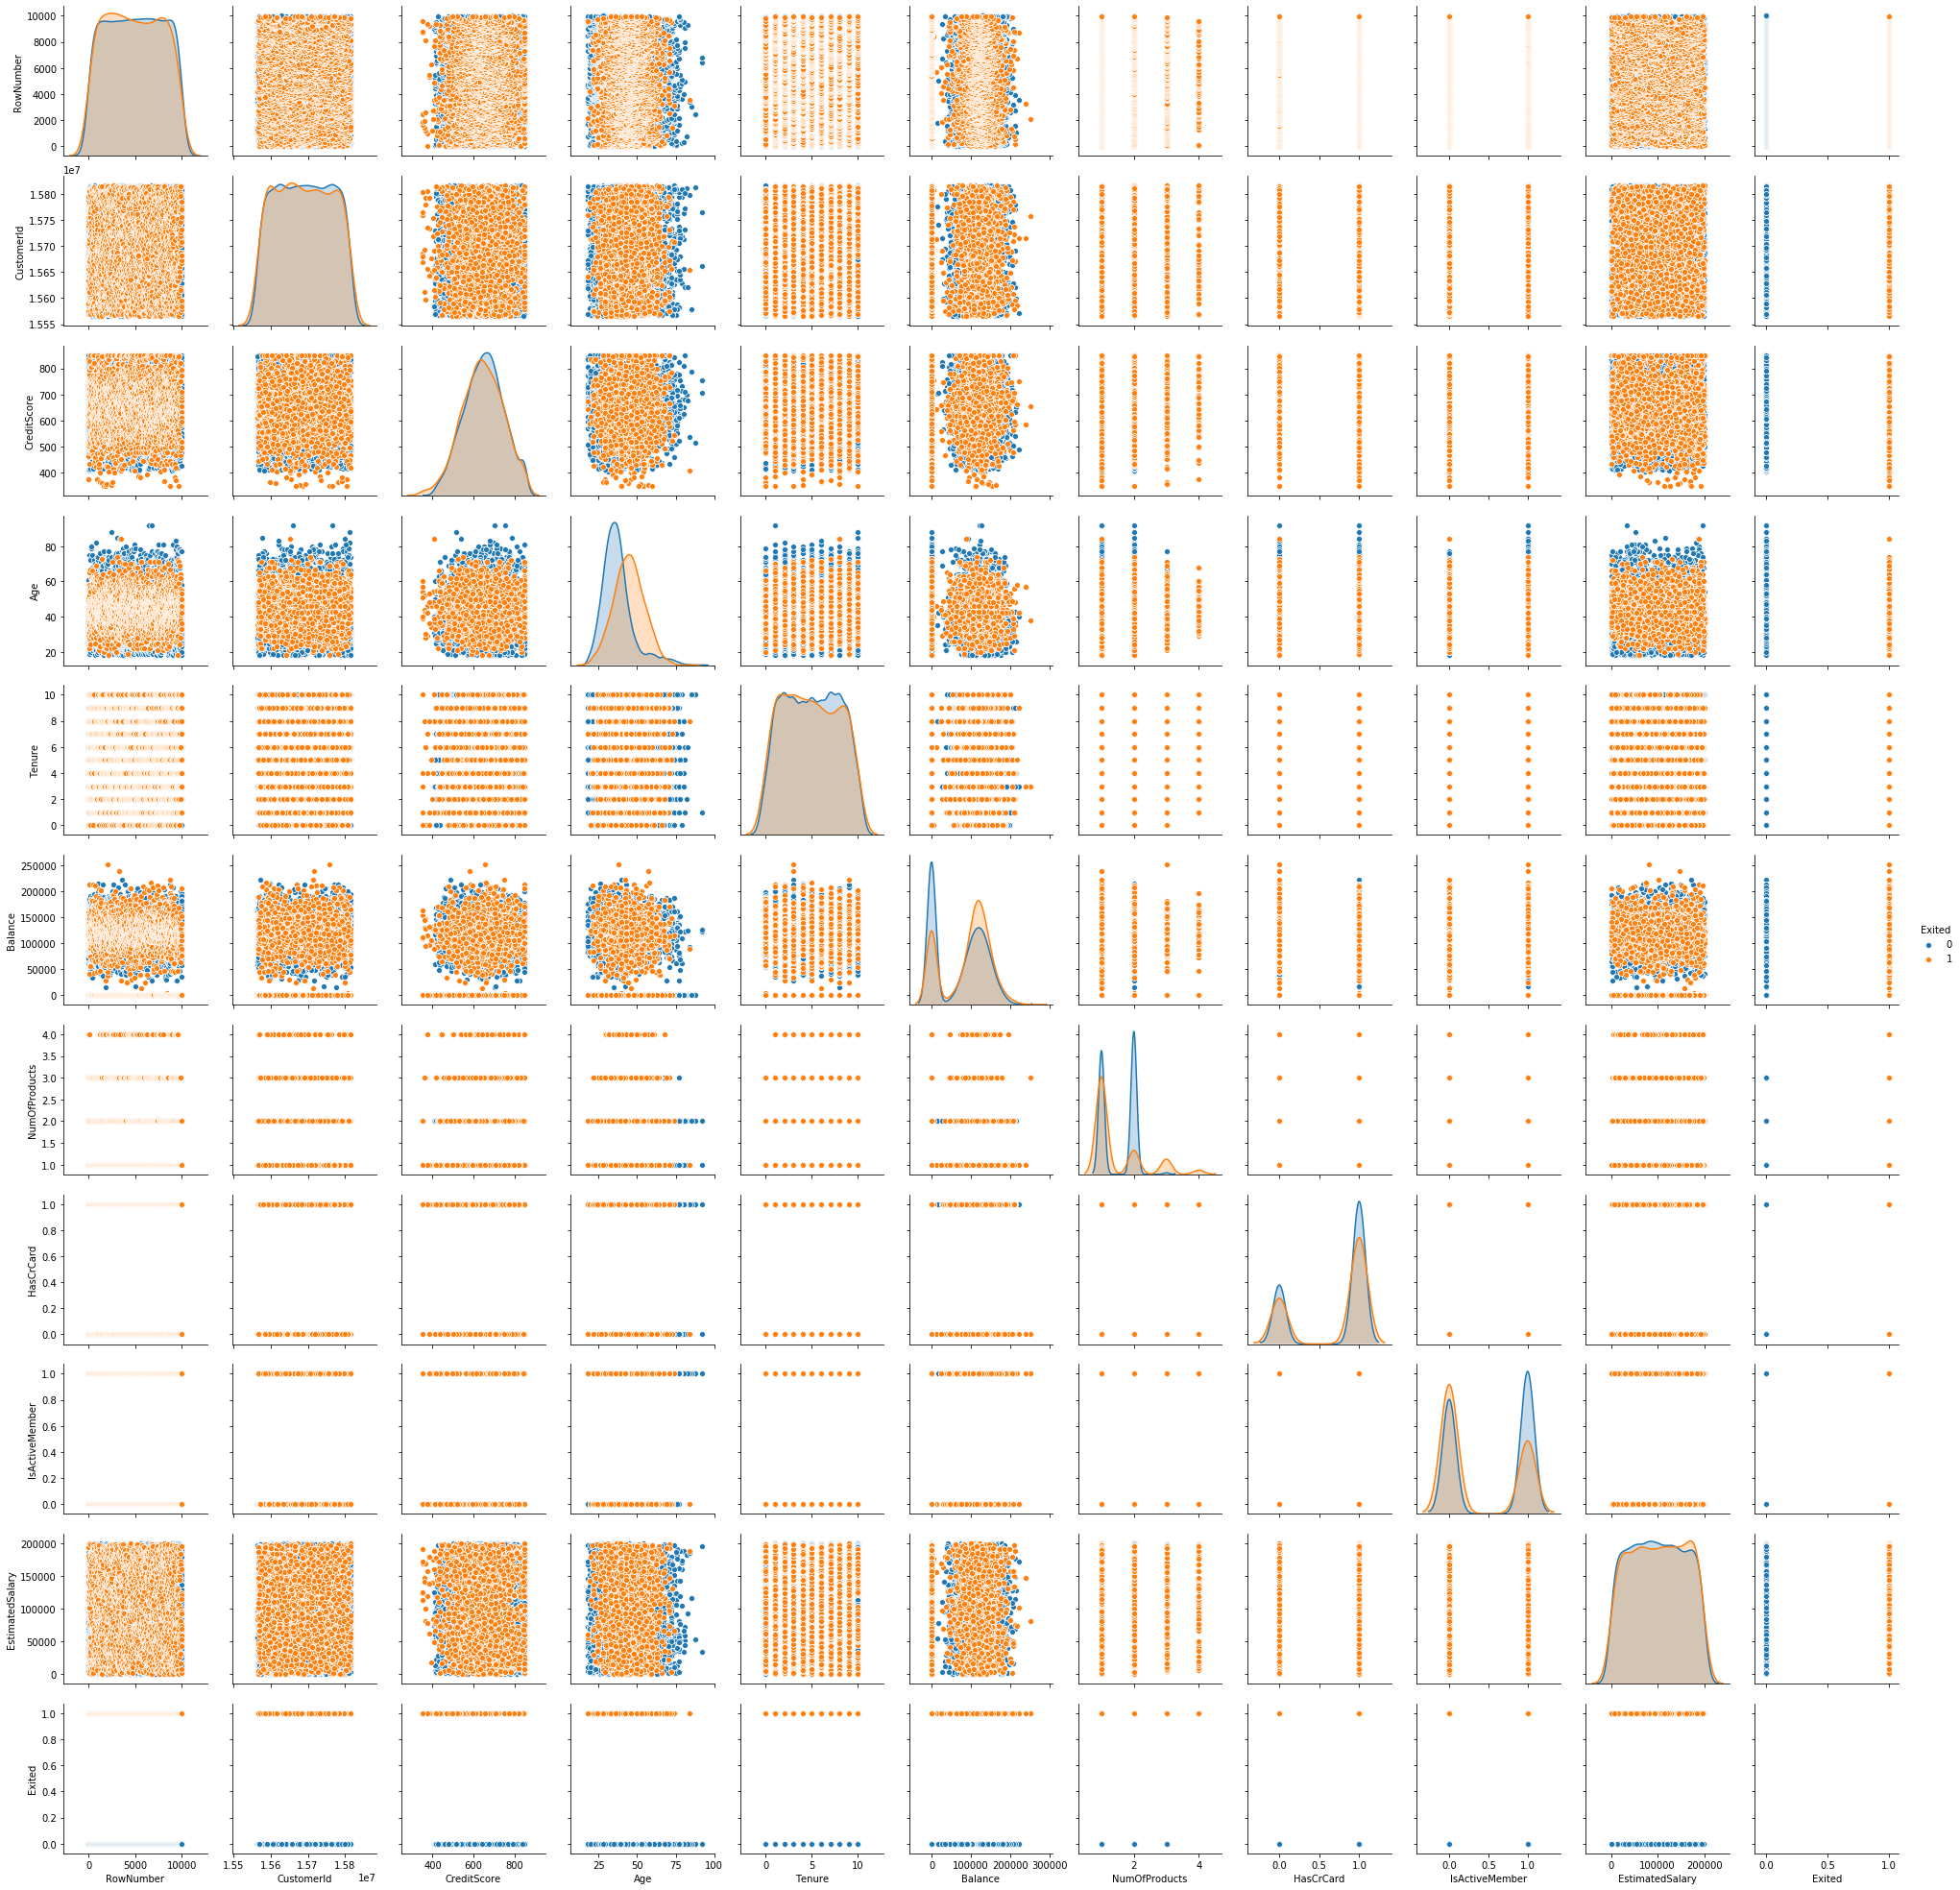

In [8]:
sns.pairplot(df, hue='Exited')
plt.show()

Тут мы видим интересную картину, кажется не все признаки одинаково полезны для нашего исследования: для `Age`, `Balance`, `NumOfProducts`, `HasCrCard` и `IsActiveMember` явно видны различия в распределении между лояльными клиентами и ушедшими к конкурентам, для остальных признаков распределения практически идентичны.

[к началу шага](#1-2) | [к началу этапа](#1) | [к началу страницы](#top)

<a id="1-3"></a>
### Шаг 1.3 OHE и заполнение пропусков

Для начала закодируем категориальные данные с помощью one-hot encoding:

In [9]:
ohe_cats = ['Geography', 'Gender']
ohe_cats = pd.get_dummies(df, columns=ohe_cats, drop_first=True)
ohe_cats.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,1,15634602,Hargrave,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,2,15647311,Hill,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,3,15619304,Onio,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,4,15701354,Boni,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,5,15737888,Mitchell,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Посмотрим на обновлённую таблицу корреляции:

In [10]:
ohe_cats.corr()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,1.000000,0.004202,0.005840,0.000783,-0.007322,-0.009067,0.007246,0.000599,0.012044,-0.005988,-0.016571,-0.000044,-0.009905,0.018196
CustomerId,0.004202,1.000000,0.005308,0.009497,-0.021418,-0.012419,0.016972,-0.014025,0.001665,0.015271,-0.006248,-0.003097,0.007800,-0.002641
CreditScore,0.005840,0.005308,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094,0.005538,0.004780,-0.002857
Age,0.000783,0.009497,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323,0.046897,-0.001685,-0.027544
Tenure,-0.007322,-0.021418,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761,-0.003299,0.000810,0.012634
Balance,-0.009067,-0.012419,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533,0.401110,-0.134892,0.012087
NumOfProducts,0.007246,0.016972,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820,-0.010419,0.009039,-0.021859
HasCrCard,0.000599,-0.014025,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138,0.010577,-0.013480,0.005766
IsActiveMember,0.012044,0.001665,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128,-0.020486,0.016732,0.022544
EstimatedSalary,-0.005988,0.015271,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097,0.010297,-0.006482,-0.008112


Оказывается, новые категории тоже имеют слабую корреляцию с целевым признаком, поэтому их включение нам не повредит.

Теперь займёмся пропущенными значениями. Разделим выборку на известную и неизвестную части:

In [11]:
ohe_cats.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
pred_index = ohe_cats[ohe_cats['Tenure'].isnull()].index
train_index = ohe_cats[~ohe_cats['Tenure'].isnull()].index

Теперь подготовим тренировочную и валидационную выборки и обучим модель:

In [12]:
X = ohe_cats.iloc[train_index].drop(['Exited', 'Tenure'], axis=1)
y = ohe_cats.iloc[train_index]['Tenure']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.25, stratify=y, random_state=STATE)

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

model = LinearRegression(normalize=True)
model.fit(X_train, y_train)
print(model.score(X_valid, y_valid))

(6818, 10) (2273, 10) (6818,) (2273,)
-0.0017421551024410233


Предскажем неизвестные значения:

In [13]:
pred_X = ohe_cats.iloc[pred_index].drop(['Exited', 'Tenure'], axis=1)
pred = model.predict(pred_X)

Подставим предсказанные значения в датафрейм и изменим тип данных на `int`:

In [14]:
pred_y = pd.Series(pred.astype('int'), index=pred_index)
ohe_cats['Tenure'].fillna(pred_y, inplace=True)
ohe_cats['Tenure'] = ohe_cats['Tenure'].astype('int')

Получим информацию о датафрейме:

In [15]:
ohe_cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
CreditScore          10000 non-null int64
Age                  10000 non-null int64
Tenure               10000 non-null int64
Balance              10000 non-null float64
NumOfProducts        10000 non-null int64
HasCrCard            10000 non-null int64
IsActiveMember       10000 non-null int64
EstimatedSalary      10000 non-null float64
Exited               10000 non-null int64
Geography_Germany    10000 non-null uint8
Geography_Spain      10000 non-null uint8
Gender_Male          10000 non-null uint8
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


Отлично! Пропусков больше нет, типы данных соответствуют задаче.

Основные показатели:

In [16]:
ohe_cats.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.953000,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.250900,0.247700,0.545700
std,96.653299,10.487806,2.767735,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.433553,0.431698,0.497932
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,0.000000,1.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,0.000000,1.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000


Показатели в норме, можно двигаться дальше. Столбец `Tenure` не испорчен, значения почти не изменились.

Однако, тут мы видим одну важную деталь: целевой признак не сбалансирован, нулевых значений значительно больше.

Теперь взглянем на графики:

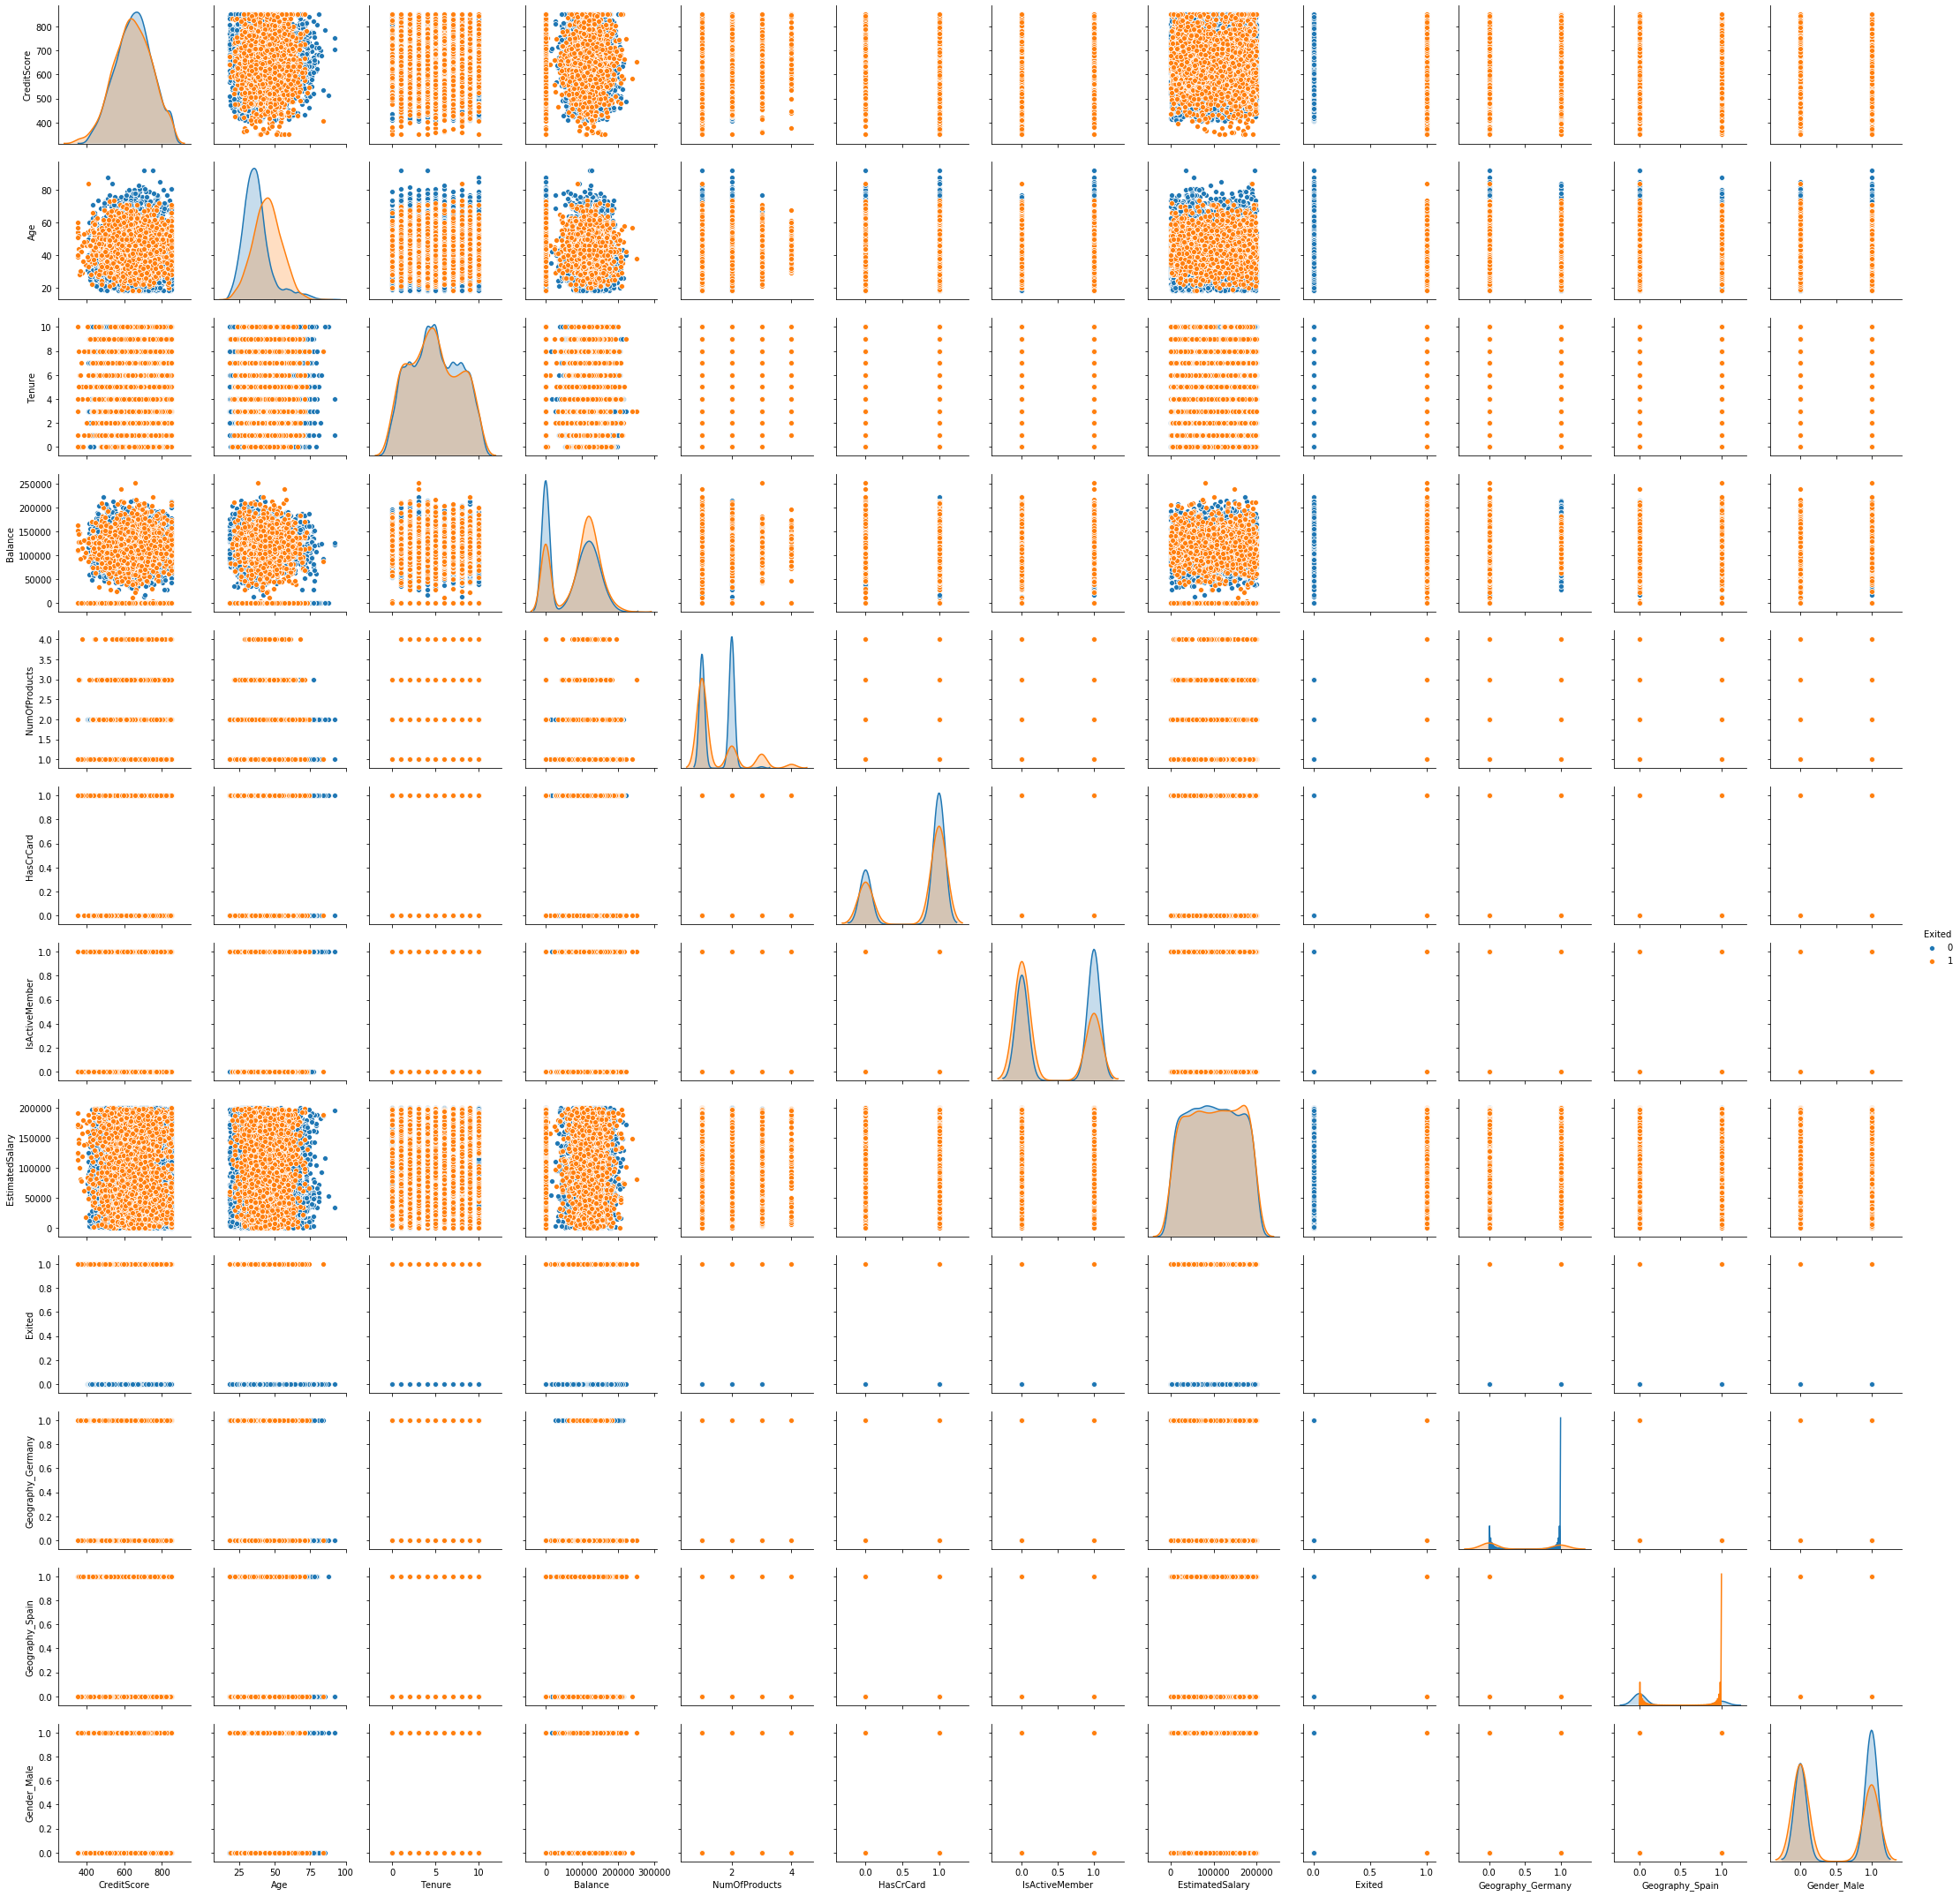

In [17]:
sns.pairplot(ohe_cats, hue='Exited')
plt.show()

Как и раньше, видна разница между важными признаками и не очень. К важным признакам добавильсь и новые закодированные категории: `Geography_Germany`, `Geography_Spain` и `Gender_Male`.

[к началу шага](#1-3) | [к началу этапа](#1) | [к началу страницы](#top)

<a id="2"></a>
## Этап 2. Исследование задачи

<a id="2-1"></a>
### Шаг 2.1 Подготовка

Данные подготовлены, теперь необходимо подготовить выборки для обучения. Для формирования выборок мы отберём необходимые параметры, а выборки разделим на обучающую, валидационную и тестовую в отношении (80/20) -> 80/20 => 64/16/20:

In [18]:
y = ohe_cats['Exited']
X = ohe_cats[['Age', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 
                   'Geography_Germany', 'Geography_Spain', 'Gender_Male']]

X_tralid, X_test, y_tralid, y_test = train_test_split(
    X, y, stratify=y, test_size=.2, random_state=STATE)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_tralid, y_tralid, stratify=y_tralid, test_size=.2, random_state=STATE)

print('Тренировочная выборка: {}.'.format(X_train.shape), 'Тренировочные результаты: {}.'.format(y_train.shape))
print('Валидационная выборка: {}.'.format(X_valid.shape), 'Валидационные результаты: {}.'.format(y_valid.shape))
print('Тренировочная + валидационная выборка: {}.'.format(X_tralid.shape), 
      'Тренировочные + валидационные результаты: {}.'.format(y_tralid.shape))
print('Тестовая выборка: {}.'.format(X_test.shape), 'Тестовые результаты: {}.'.format(y_test.shape))

Тренировочная выборка: (6400, 8). Тренировочные результаты: (6400,).
Валидационная выборка: (1600, 8). Валидационные результаты: (1600,).
Тренировочная + валидационная выборка: (8000, 8). Тренировочные + валидационные результаты: (8000,).
Тестовая выборка: (2000, 8). Тестовые результаты: (2000,).


Также напишем функцию для подбора гиперпараметров по целевой метрике f1:

In [19]:
#  объявляем переменные для хранения лучших гиперпараметров и метрик
tree_best, forest_best, logreg_best = {}, {}, {}
tree_stats, forest_stats, logreg_stats = ['Решающее дерево'], ['Случайный лес'], ['Логистическая регрессия']

def grid_search(clf, grid_params, features_train, features_valid, target_train, target_valid):
    global tree_best, forest_best, logreg_best  #  обращаемся к переменным как к глобальным
    
    #  с помощью поиска по сетке определяем наилучшую версию модели
    grid = GridSearchCV(clf, grid_params, scoring = 'f1', cv=5, n_jobs=-1)
    grid.fit(features_train, target_train)
    
    #  выводим информацию о наилучшей версии модели
    print('Гиперпараметры наилучшей модели:', grid.best_params_)
    print('f1 наилучшей модели на обучающей выборке:', f1_score(target_train, grid.predict(features_train)))
    print('f1 наилучшей модели на валидационной выборке:', f1_score(target_valid, grid.predict(features_valid)))
    print('ROC-AUC наилучшей модели на обучающей выборке:', roc_auc_score(target_valid, grid.predict(features_valid)))
    

    
    #  сохраняем гиперпараметры и метрики точности лучшей версии модели
    if  type(clf).__name__ == 'DecisionTreeClassifier':
        tree_best = grid.best_params_
        tree_stats.extend([f1_score(target_train, grid.predict(features_train)), 
                           f1_score(target_valid, grid.predict(features_valid))])
    elif type(clf).__name__ == 'RandomForestClassifier':
        forest_best = grid.best_params_
        forest_stats.extend([f1_score(target_train, grid.predict(features_train)),
                             f1_score(target_valid, grid.predict(features_valid))])
    else:
        logreg_best = grid.best_params_
        logreg_stats.extend([f1_score(target_train, grid.predict(features_train)), 
                             f1_score(target_valid, grid.predict(features_valid))])

Теперь перейдем к изучению моделей!

[к началу шага](#2-1) | [к началу этапа](#2) | [к началу страницы](#top)

<a id="2-2"></a>
### Шаг 2.2 Логистическая регрессия

Начнём с логистической регрессии:

In [20]:
%%time
logreg_clf = LogisticRegression(random_state=STATE)
logreg_params = [
  {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': [0.1, 0.5, 1, 5, 10, 50, 100]},
  {'penalty': ['l2'], 'solver': ['liblinear', 'saga', 'sag', 'lbfgs', 'newton-cg'], 'C': [0.1, 0.5, 1, 5, 10, 50, 100]},
  ]

print('Логистическая регрессия')
grid_search(logreg_clf, logreg_params, X_train, X_valid, y_train, y_valid)

Логистическая регрессия
Гиперпараметры наилучшей модели: {'C': 50, 'penalty': 'l2', 'solver': 'newton-cg'}
f1 наилучшей модели на обучающей выборке: 0.31058020477815707
f1 наилучшей модели на валидационной выборке: 0.30484988452655887
ROC-AUC наилучшей модели на обучающей выборке: 0.5851359420596931
CPU times: user 3min 15s, sys: 3min 11s, total: 6min 26s
Wall time: 6min 26s


Как видим, показатели далеки от целевых, только ROC-AUC лучше средних значений, а f1 просто мимо.

[к началу шага](#2-2) | [к началу этапа](#2) | [к началу страницы](#top)

<a id="2-3"></a>
### Шаг 2.3 Решающее дерево

Посмотрим как дела у решающего дерева:

In [21]:
%%time
tree_clf = DecisionTreeClassifier(random_state=STATE)
tree_params = {'max_depth': range(1, 11),
               'criterion': ['entropy', 'gini']}

print('Решающее дерево')
grid_search(tree_clf, tree_params, X_train, X_valid, y_train, y_valid)

Решающее дерево
Гиперпараметры наилучшей модели: {'criterion': 'entropy', 'max_depth': 8}
f1 наилучшей модели на обучающей выборке: 0.6261197548326262
f1 наилучшей модели на валидационной выборке: 0.579047619047619
ROC-AUC наилучшей модели на обучающей выборке: 0.7146829944814169
CPU times: user 1.49 s, sys: 0 ns, total: 1.49 s
Wall time: 1.5 s


На обучающей выборке удалось достичь целевых показателей, а вот на валидационной уже нет. Это лучше, чем у логистической регрессии, но всё ещё недостаточно хорошо. ROC-AUC при этом уже на более достойном уровне.

[к началу шага](#2-3) | [к началу этапа](#2) | [к началу страницы](#top)

<a id="2-4"></a>
### Шаг 2.4 Случайный лес

Настал черёд тяжёлой артиллерии, достаём из рукава случайный лес:

In [22]:
%%time
forest_clf = RandomForestClassifier(random_state=STATE)
forest_params = {'n_estimators': range(10, 151, 10),
               'max_depth': range(1, 11), 
               'criterion': ['entropy', 'gini']}

print('Случайный лес')
grid_search(forest_clf, forest_params, X_train, X_valid, y_train, y_valid)

Случайный лес
Гиперпараметры наилучшей модели: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 140}
f1 наилучшей модели на обучающей выборке: 0.6795366795366795
f1 наилучшей модели на валидационной выборке: 0.5548902195608783
ROC-AUC наилучшей модели на обучающей выборке: 0.6990614556346371
CPU times: user 7min 42s, sys: 0 ns, total: 7min 42s
Wall time: 7min 47s


Значения на обучающей выборке оказались лучше, чем у дерева, а вот на валидационной лес оказался хуже дерева. Причём это касается как f1, так и ROC-AUC. Налицо переобучение.

[к началу шага](#2-4) | [к началу этапа](#2) | [к началу страницы](#top)

<a id="2-5"></a>
### Шаг 2.5 Баланс и ROC-AUC

Как мы уже установили, классы в выборке непропорциональны, поэтому результаты моделей могут получаться неоптимальными. Для начала узнаем количество представлений каждого класса:

In [23]:
ohe_cats.groupby('Exited')['Age'].count()

Exited
0    7963
1    2037
Name: Age, dtype: int64

Нулевой класс почти в 4 раза больше, с такой несбалансированностью стоит что-то сделать.

А пока определим функцию для рисования кривых ROC-AUC:

In [24]:
def plt_roc_auc(models, features, target):
    plt.figure(figsize=(8, 5), dpi=80)
    for model in models:
        probabilities_valid = model.predict_proba(features)
        probabilities_one_valid = probabilities_valid[:, 1]
        fpr, tpr, thresholds = roc_curve(target, probabilities_one_valid)
        plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend([type(model).__name__ for model in models])
    plt.show()

И сразу же её применим:

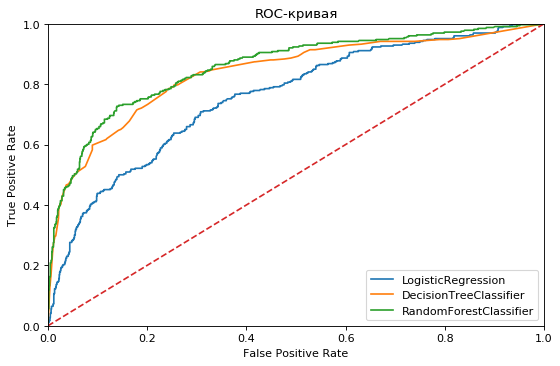

In [25]:
logreg_model = LogisticRegression(random_state=STATE, **logreg_best)
logreg_model.fit(X_train, y_train)

tree_model = DecisionTreeClassifier(random_state=STATE, **tree_best)
tree_model.fit(X_train, y_train)

forest_model = RandomForestClassifier(random_state=STATE, **forest_best)
forest_model.fit(X_train, y_train)

plt_roc_auc([logreg_model, tree_model, forest_model], X_valid, y_valid)

Видим, что кривые для дерева и леса очень похожи, кривая для регрессии заметно ниже, но все три модели выглядят лучше среднего.

[к началу шага](#2-5) | [к началу этапа](#2) | [к началу страницы](#top)

<a id="3"></a>
## Этап 3. Борьба с дисбалансом

<a id="3-1"></a>
### Шаг 3.1 Балансировка

Теперь приступим к балансировке выборки. Для начала напишем функцию для оценки моделей:

In [26]:
def print_stats(model, features_valid, target_valid):
    if type(model).__name__ == 'RandomForestClassifier':
        print('Случайный лес')
        stats = forest_stats
    elif type(model).__name__ == 'DecisionTreeClassifier':
        print('Решающее дерево')
        stats = tree_stats
    else:
        print('Логистическая регрессия')
        stats = logreg_stats
    
    print('f1 несбалансированной модели на валидационной выборке:', stats[2])
    stats.append(f1_score(target_valid, model.predict(features_valid)))
    print('f1 сбалансированной модели на валидационной выборке:', stats[-1])
    print('ROC-AUC сбалансированной модели на валидационной выборке:', 
          roc_auc_score(target_valid, model.predict(features_valid)))

Теперь проверим как модели себя проявят с дополнительным параметром `class_weight='balanced'`:

In [27]:
logreg_model = LogisticRegression(random_state=STATE, class_weight='balanced', **logreg_best)
logreg_model.fit(X_train, y_train)
print_stats(logreg_model, X_valid, y_valid)

Логистическая регрессия
f1 несбалансированной модели на валидационной выборке: 0.30484988452655887
f1 сбалансированной модели на валидационной выборке: 0.48577680525164113
ROC-AUC сбалансированной модели на валидационной выборке: 0.6968487253325115


Логистическая регрессия довольно сильно прибавила, теперь значение f1 близко к 0.5, что уже неплохо. Однако, до целевого значения метрики это всё ещё далеко.

In [28]:
tree_model = DecisionTreeClassifier(random_state=STATE, class_weight='balanced', **tree_best)
tree_model.fit(X_train, y_train)
print_stats(tree_model, X_valid, y_valid)

Решающее дерево
f1 несбалансированной модели на валидационной выборке: 0.579047619047619
f1 сбалансированной модели на валидационной выборке: 0.5731857318573186
ROC-AUC сбалансированной модели на валидационной выборке: 0.7576759349327272


Дерево, на удивление, показало обратный результат: после балансировки значение метрики только снизилось.

In [29]:
forest_model = RandomForestClassifier(random_state=STATE, class_weight='balanced', **forest_best)
forest_model.fit(X_train, y_train)
print_stats(forest_model, X_valid, y_valid)

Случайный лес
f1 несбалансированной модели на валидационной выборке: 0.5548902195608783
f1 сбалансированной модели на валидационной выборке: 0.6294706723891272
ROC-AUC сбалансированной модели на валидационной выборке: 0.7773762171220542


Метрика f1 у леса наконец добралась до значений, близких к тренировочным. Теперь значение превышает целевой показатель и на валидационной выборке. Отлично!

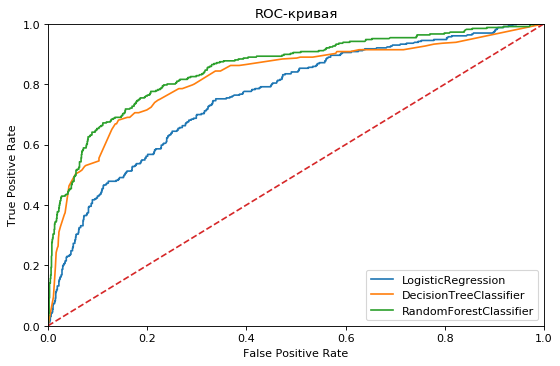

In [30]:
plt_roc_auc([logreg_model, tree_model, forest_model], X_valid, y_valid)

Для сбалансированной выборки вид кривых слегка преобразился. Позиции леса и регрессии выросли, а дерево слегка потеряло позиции. Однако, в целом картина изменилась не очень сильно.

[к началу шага](#3-1) | [к началу этапа](#3) | [к началу страницы](#top)

<a id="3-2"></a>
### Шаг 3.2 Уменьшение выборки

Попробуем примениить другой вариант борьбы с дисбалансом &mdash; уменьшить выборку. Для начала напишем функцию для уменьшения выборки:

In [31]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

Применим эту функцию к нашей выборке:

In [32]:
X_downtrain, y_downtrain = downsample(X_train, y_train, .25)
print(X_downtrain.shape, y_downtrain.shape)

(2578, 8) (2578,)


И посмотрим как модели поведут себя на такой выборке:

In [33]:
logreg_model = LogisticRegression(random_state=STATE, **logreg_best)
logreg_model.fit(X_downtrain, y_downtrain)
print_stats(logreg_model, X_valid, y_valid)

Логистическая регрессия
f1 несбалансированной модели на валидационной выборке: 0.30484988452655887
f1 сбалансированной модели на валидационной выборке: 0.48380129589632836
ROC-AUC сбалансированной модели на валидационной выборке: 0.6959915632132987


Для логистической регрессии уменьшение выборки произвело аналогичный простой балансировке эффект.

In [34]:
tree_model = DecisionTreeClassifier(random_state=STATE, **tree_best)
tree_model.fit(X_downtrain, y_downtrain)
print_stats(tree_model, X_valid, y_valid)

Решающее дерево
f1 несбалансированной модели на валидационной выборке: 0.579047619047619
f1 сбалансированной модели на валидационной выборке: 0.5460750853242321
ROC-AUC сбалансированной модели на валидационной выборке: 0.7452567152391867


Для дерева как простая балансировка, так и уменьшение выборки не приносит дополнительного улучшения.

In [35]:
forest_model = RandomForestClassifier(random_state=STATE, **forest_best)
forest_model.fit(X_downtrain, y_downtrain)
print_stats(forest_model, X_valid, y_valid)

Случайный лес
f1 несбалансированной модели на валидационной выборке: 0.5548902195608783
f1 сбалансированной модели на валидационной выборке: 0.5885225885225884
ROC-AUC сбалансированной модели на валидационной выборке: 0.7707308029393919


Для случайного леса уменьшение выборки даёт улучшение, но мера f1 не доходит до целевого значения, а простая балансировка всё равно даёт б**о**льший прирост.

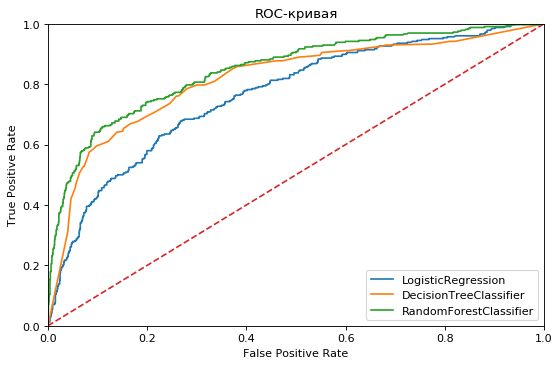

In [36]:
plt_roc_auc([logreg_model, tree_model, forest_model], X_valid, y_valid)

Опять же, графики кривых сильно не изменились, в целом ситуация остаётся такой же.

[к началу шага](#3-2) | [к началу этапа](#3) | [к началу страницы](#top)

<a id="3-3"></a>
### Шаг 3.3 Увеличение выборки

Теперь попробуем победить дисбаланс с помощью увеличения выборки. Напишем функцию для апсэмплинга:

In [37]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

И увеличим выборку:

In [38]:
X_uptrain, y_uptrain = upsample(X_train, y_train, 4)
print(X_uptrain.shape, y_uptrain.shape)

(10312, 8) (10312,)


Посмотрим на метрики моделей с новой выборкой:

In [39]:
logreg_model = LogisticRegression(random_state=STATE, **logreg_best)
logreg_model.fit(X_uptrain, y_uptrain)
print_stats(logreg_model, X_valid, y_valid)

Логистическая регрессия
f1 несбалансированной модели на валидационной выборке: 0.30484988452655887
f1 сбалансированной модели на валидационной выборке: 0.4832793959007551
ROC-AUC сбалансированной модели на валидационной выборке: 0.6955990985351196


Опять же, логистическая регрессия показывает результат лучше первоначального, однако идентичный другим вариантам борьбы с дисбалансом. 

In [40]:
tree_model = DecisionTreeClassifier(random_state=STATE, **tree_best)
tree_model.fit(X_uptrain, y_uptrain)
print_stats(tree_model, X_valid, y_valid)

Решающее дерево
f1 несбалансированной модели на валидационной выборке: 0.579047619047619
f1 сбалансированной модели на валидационной выборке: 0.5714285714285715
ROC-AUC сбалансированной модели на валидационной выборке: 0.7561421926014388


Для дерева такой вариант также не оказался удачным.

In [41]:
forest_model = RandomForestClassifier(random_state=STATE, **forest_best)
forest_model.fit(X_uptrain, y_uptrain)
print_stats(forest_model, X_valid, y_valid)

Случайный лес
f1 несбалансированной модели на валидационной выборке: 0.5548902195608783
f1 сбалансированной модели на валидационной выборке: 0.608355091383812
ROC-AUC сбалансированной модели на валидационной выборке: 0.7761217748071385


Для случайного леса апсэмплинг показал достаточный результат, однако простая балансировка всё еще лучше.

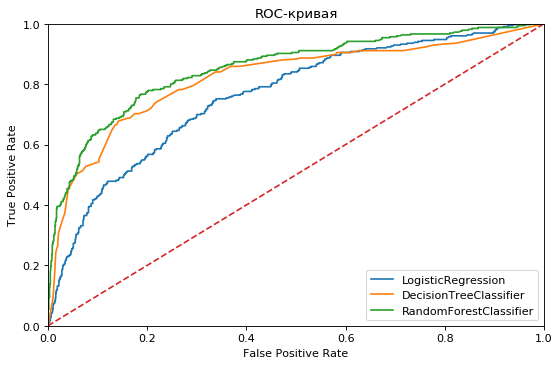

In [42]:
plt_roc_auc([logreg_model, tree_model, forest_model], X_valid, y_valid)

Ничего удивительного с кривыми ROC не произошло.

[к началу шага](#3-3) | [к началу этапа](#3) | [к началу страницы](#top)

<a id="3-4"></a>
### Шаг 3.4 Выбор модели

Теперь посмотрим на всю собранную статистику и выберем наилучшую модель:

In [43]:
stats = pd.DataFrame([tree_stats, forest_stats, logreg_stats], 
                     columns=['model', 'train', 'valid unbalanced', 
                              'valid balanced ', 'valid downsampled', 'valid upsampled'])

display(stats.sort_values(by='train', ascending=False))

,model,train,valid unbalanced,valid balanced,valid downsampled,valid upsampled
1,Случайный лес,0.679537,0.554890,0.629471,0.588523,0.608355
0,Решающее дерево,0.626120,0.579048,0.573186,0.546075,0.571429
2,Логистическая регрессия,0.310580,0.304850,0.485777,0.483801,0.483279


Как видим, по валидационной выборке целевого показателя достиг только случайный лес с балансировкой и случайный лес с апсэмплингом. Остальные модели не достигли требуемых значений по метрике f1.

Из двух вариантов лучше выбрать простую балансировку, так как значение f1 у неё немного выше, применить её проще и она не изменяет структуру датасета.

[к началу шага](#3-4) | [к началу этапа](#3) | [к началу страницы](#top)

<a id="4"></a>
## Этап 4. Тестирование модели

<a id="4-1"></a>
### Шаг 4.1 Подбор гиперпараметров

Заново подберём гиперпараметры, так как для сбалансированной модели оптимальные значения могут быть другими:

In [44]:
%%time
forest_clf = RandomForestClassifier(random_state=STATE, class_weight='balanced')

print('Случайный лес')
grid_search(forest_clf, forest_params, X_train, X_valid, y_train, y_valid)

Случайный лес
Гиперпараметры наилучшей модели: {'criterion': 'gini', 'max_depth': 9, 'n_estimators': 130}
f1 наилучшей модели на обучающей выборке: 0.7170596393897364
f1 наилучшей модели на валидационной выборке: 0.618181818181818
ROC-AUC наилучшей модели на обучающей выборке: 0.7730229892806579
CPU times: user 7min 36s, sys: 0 ns, total: 7min 36s
Wall time: 7min 47s


Как и предполагалось, оптимальные гиперпараметры для сбалансированной модели отличаются.

[к началу шага](#4-1) | [к началу этапа](#4) | [к началу страницы](#top)

<a id="4-2"></a>
### Шаг 4.2 Обучение

Теперь обучим модель на объединенной выборке и проверим на тестовой:

In [45]:
forest_model = RandomForestClassifier(random_state=STATE, class_weight='balanced', **forest_best)
forest_model.fit(X_tralid, y_tralid)

print('Случайный лес')
print('f1 наилучшей модели на тестовой выборке:', f1_score(y_test, forest_model.predict(X_test)))
print('ROC-AUC наилучшей модели на тестовой выборке:', roc_auc_score(y_test, forest_model.predict(X_test)))

Случайный лес
f1 наилучшей модели на тестовой выборке: 0.6291390728476821
ROC-AUC наилучшей модели на тестовой выборке: 0.782953986343817


Отлично, модель показала меру f1 на тестовой выборке приблизительно равную `0.6291`, что больше целевой в `0.59`. Задание выполнено!

Что интересно, значение ROC-AUC также оказалось наибольшим.

[к началу шага](#4-2) | [к началу этапа](#4) | [к началу страницы](#top)

<a id="4-3"></a>
### Шаг 4.3 Проверка на адекватность

Проверим нашу модель на адекватность и проверим, как её предсказания отличаются от предсказаний случайной модели:

In [46]:
dummy_clf = DummyClassifier(random_state=STATE)
dummy_clf.fit(X_tralid, y_tralid)
predictions_sanity = dummy_clf.predict(X_test)

print('Случайное распределение')
print('f1 случайной модели на объединённой выборке:', dummy_clf.score(X_tralid, y_tralid))
print('f1 случайной модели на тестовой выборке:', f1_score(y_test, predictions_sanity))
print('ROC-AUC случайной модели на тестовой выборке:', roc_auc_score(y_test, predictions_sanity))

Случайное распределение
f1 случайной модели на объединённой выборке: 0.677875
f1 случайной модели на тестовой выборке: 0.1873479318734793
ROC-AUC случайной модели на тестовой выборке: 0.48850545460714956


Как видим, хоть метрика на объединённой выборке довольно конкурентная, при переходе к тестовой выборке метрика f1 падает до неприлично низких значений. ROC-AUC примерно равен `0.5`, что похоже на правду для случайно модели.

В любом случае, наша модель адекватно предсказывает целевой признак, поэтому проходит проверку на адекватность.

[к началу шага](#4-3) | [к началу этапа](#4) | [к началу страницы](#top)

<a id="5"></a>
## Этап 5. Результаты исследования

<a id="5-1"></a>
### Шаг 5.1 Общие выводы

В этом исследовании мы подбирали наилучшую модель для предсказания того, уйдёт ли клиент из банка в ближайшее время на основании данных о 10&nbsp;000 клиентов. Так как исхода всего два (ушёл или не ушёл), задача свелась к бинарной классификации.

Перед обучением моделей мы провели предварительную подгототовку данных и их анализ. Сначала мы методом OHE закодировали категориальные признаки. Далее предсказали пропущенные значения параметра `Tenure` и привели столбец к типу данных `int`. Затем мы изучили влияние параметров на результат и отобрали значимые параметры: `Age`, `Balance`, `NumOfProducts`, `HasCrCard`, `IsActiveMember`, `Geography_Germany`, `Geography_Spain`, `Gender_Male`. Рекомендуется обратить внимаение на эти параметры, так как имено они имеют наибольшую связь с уходом клиента из банка. Кроме того, при анализе параметров, мы установили, что нулевых значений целевого признака примерно в четыре раза больше, то есть выборка несбалансированная.

В рамках задачи бинарной классификации мы рассмотрели 3 модели:

- логистическая регрессия (`LogisticRegression`);
- решающее дерево (`DecisionTreeClassifier`);
- случайный лес (`RandomForestClassifier`).

Каждую модель мы обучили на нескольких типах выборок: первое обучение происходило на предварительной выборке 80% от всего датасета, который мы в свою очередь разделили в пропорции 80/20 на обучающую (64% от всех данных) и валидационную (16% от всех данных) выборки. Затем, после определения наилучших гиперпараметров для каждой модели мы заново обучили их на объединённой обучающей и валидационной (80% от всех данных) выборке, а точность проверили на тестовой выборке (20% данных). Во всех выборках тарифы были представлены в одинаковых пропорциях, характерных для всего датасета.

Для всех моделей мы подбирали наилучшие гиперпараметры. Для дерева наилучший результат был достигнут при наборе гиперпараметров `{'criterion': 'entropy', 'max_depth': 8}`, для леса — при значениях гиперпараметров `{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 140}`, а для логистической регрессии — `{'C': 50, 'penalty': 'l2', 'solver': 'newton-cg'}`.

По предварительному условию, удовлетворительной считается модель со значением f1 не менее 0.59. Мы проверили f1 для каждой модели, и только у случайного леса на тренировочной выборке мера f1 выше удовлетворительной. Однако, на валидационной выборке ни одна модель не смогла показать удовлетворительный результат.

С учетом информации о несбалансированности выборки, мы начали применять различные средства борьбы с несбалансированностью. Изучив результаты моделей после простой балансировки, даунсэмплинга и апсэмплинга, мы пришли к выводу, что единственной моделью, которая смогла получить адекватный результат стала модель случайного леса либо с простой балансировкой, либо с апсэмплингом. Однако мы выбрали простую балансировку, так как значение f1 у неё немного выше, применить её проще и она не изменяет структуру датасета.

После выбора способа балансировки мы заново провели подбор гиперпараметров, и лучший вариант несколько изменился. Также мы провели sanity check для лучшей модели. Модель выдаёт заметно лучшие результаты, чем просто случайное распределение, то есть проверка на адекватность пройдена.

Резюмируя, можно сказать что в целях предсказания ухода клиента допустимо использовать модель случайного леса с простой балансировкой. Рекомендованные гиперпараметры: `{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 130}`.

Самая лучшая мера f1 (`0.6291`) достигнута с помощью модели случайного леса с гиперпараметрами `{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 130}`.

Самая лучшая мера ROC-AUC (`0.7830`) достигнута с помощью модели случайного леса с гиперпараметрами `{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 130}`.

[к началу шага](#5-1) | [к началу этапа](#5) | [к началу страницы](#top)

<a id="5-2"></a>
### Шаг 5.2 Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*

[к началу шага](#5-2) | [к началу этапа](#5) | [к началу страницы](#top)